In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.distributions as dist
import torch.optim as optim

import lic.ppl as ppl
from lic.ppl.world import World
from lic.ppl.model.statistical_model import StatisticalModel
import lic.ppl.experimental.inference_compilation.ic_infer as ic_infer

sns.set_style('darkgrid')

import importlib
importlib.reload(ic_infer)

<module 'lic.ppl.experimental.inference_compilation.ic_infer' from '/workspaces/jupyter-data/lightweight-inference-compilation/src/lic/ppl/experimental/inference_compilation/ic_infer.py'>

In [3]:
print(
    torch.cuda.is_available(),
    torch.cuda.current_device(),
)
#device = torch.device("cuda")
device = torch.device("cpu")

True 0


In [5]:
std = 2.0
sigma = 0.1

@ppl.random_variable
def p():
    return dist.Normal(
        torch.tensor(0.).to(device=device), 
        torch.tensor(std).to(device=device)
    )

@ppl.random_variable
def x():
    return dist.Normal(
        p(),
        torch.tensor(sigma).to(device=device)
    )

In [7]:
import importlib; importlib.reload(ic_infer)
ic = ic_infer.ICInference()
ic.compile(
    [x()],
    num_worlds=1e3,
    batch_size=1,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-3),
)
samples = ic.infer(
    [p()], 
    {x(): torch.tensor(1.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)

Loss: tensor([-0.2227], grad_fn=<AddBackward0>)


In [24]:
def ic_proposal_dist(ic, obs):
    q = [p()]
    o = {x(): torch.tensor(obs, dtype=torch.float32)}
    with World() as w:
        w.queries_ = q
        w.observations_ = o
        for i in w.queries_ + list(w.observations_.keys()):
            w.call(i)
        proposal_dist = ic.find_best_single_site_proposer(q[0]).get_proposal_distribution(
            q[0],
            w.get_node_in_world_raise_error(q[0]),
            w,
            {}
        )[0].proposal_distribution
    
    return proposal_dist

In [25]:
data = []
for obs in np.linspace(-10,10,num=50):
    proposal_dist = ic_proposal_dist(ic, obs)
    ic_params = (
        proposal_dist.component_distribution.base_dist.loc.item(),
        proposal_dist.component_distribution.base_dist.scale.item()
    )
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)
melted = data.melt(id_vars=['obs_val'])

In [26]:
dd = melted[
    melted['variable'].map(lambda x: x.endswith("mean"))
]
dd = dd.rename(columns={
    'obs_val': 'y (Observed value)',
})
dd['variable'] = dd['variable'].replace({
    'anal_mean': 'Closed-form mean',
    'ic_mean': 'Mean of LIC proposer',
})

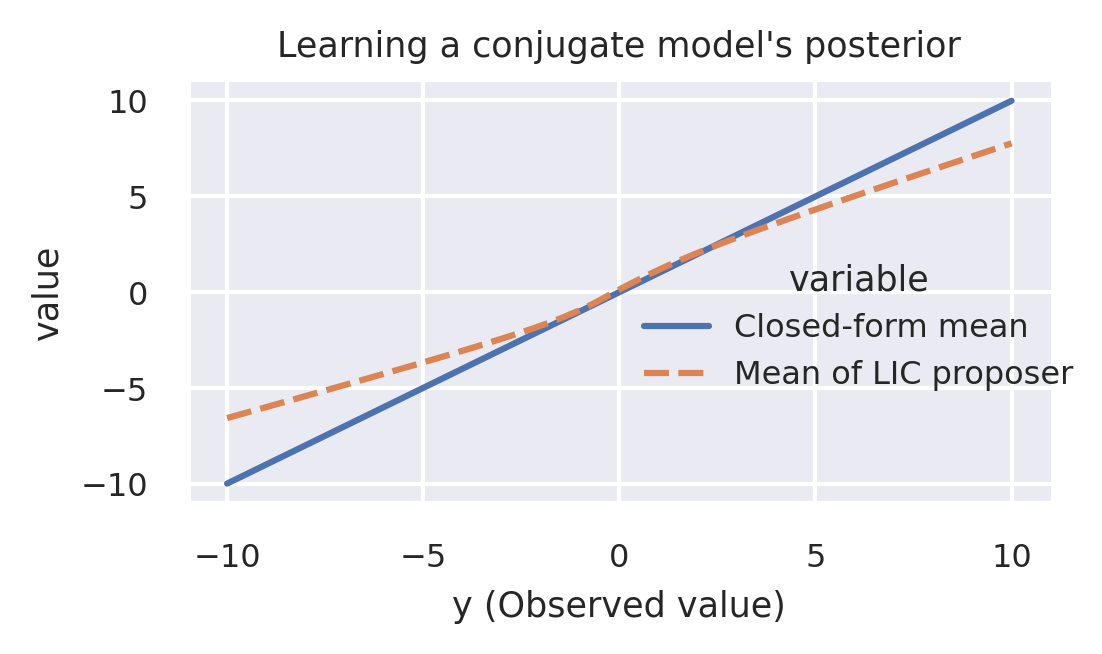

In [33]:
import pickle
#pickle.dump(dd, open("outputs/normalnormal.pkl", "wb"))
dd = pickle.load(open("outputs/normalnormal.pkl", "rb"))
sns.set(font_scale=0.7)
g = sns.relplot(
    data=dd,
    x='y (Observed value)',
    y='value',
    hue='variable',
    kind='line',
    style='variable',
)
g.set(title="Learning a conjugate model's posterior")
g.fig.set_size_inches(8.5*0.4, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('normal_normal_mean.pdf', dpi=300, bbox_inches='tight')